In [10]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [11]:
config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'
img_size= 416
conf_thres= 0.8
nms_thres= 0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()

model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

c:\users\fonse\pythonenvs\venv_lab\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [59]:
def filter_overlap(boxes):
    # boxes (x1, y1, x2, y2, object_conf, class_score, class_pred)
    subset = boxes[(boxes[:,4]>.9) & (boxes[:,5] >.9)] # getting the items whose object confidence and class score are high
    sorted, indices = torch.sort(subset[:,0])
    subset = subset[indices]
    subset_ = torch.zeros(1,7)
    i=0
    while i < len(subset)-1:
        if i == 0:
            subset_ = subset[i]
            i+=1
        else:
            if (subset[i+1][0] - subset[i][0])/(subset[i][2] - subset[i][0]) < .2:
                subset_ = torch.cat((subset_,subset[i+1]),0)
                i+=2
            else:
                subset_ = torch.cat((subset_,subset[i]),0)
                i+=1
    subset_ = subset_.view(-1,7)
    return subset_

In [60]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    
    
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 10, conf_thres, nms_thres)
    return detections[0]

In [61]:
listOfImages = os.listdir('data/water_meter/images/')

def rand_image(debug = False):
    file = 'data/water_meter/images/'+listOfImages[np.random.randint(0,338)]
    if debug == True: print(file)
    return file

Inference Time: 0:00:00.376743


<Figure size 432x288 with 0 Axes>

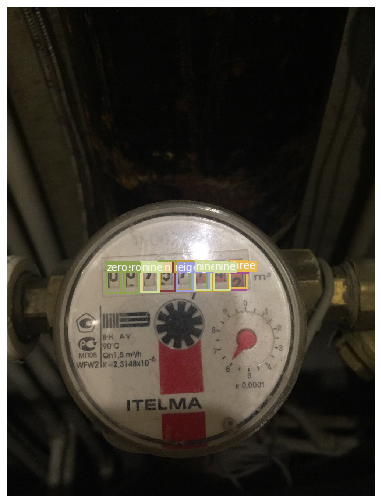

In [62]:
# load image and get detections
img_path = 'data/water_meter/images/id_667_value_957_742.jpg'
prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

pred= []
if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
        pred.append(cls_pred)
plt.axis('off')
# save image
#plt.savefig(img_path.replace(".jpg", "-det.jpg"), bbox_inches='tight', pad_inches=0.0)
plt.show()

In [63]:
def pred(img_path):
    # load image and get detections
    prev_time = time.time()
    img = Image.open(img_path)
    detections = detect_image(img)
    detections = filter_overlap(detections)
    inference_time = datetime.timedelta(seconds=time.time() - prev_time)
    print ('Inference Time: %s' % (inference_time))

    # Get bounding-box colors
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    img = np.array(img)
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(img)

    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    pred = []
    if detections is not None:
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
        # browse detections and draw bounding boxes
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            box_h = ((y2 - y1) / unpad_h) * img.shape[0]
            box_w = ((x2 - x1) / unpad_w) * img.shape[1]
            y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
            x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(bbox)
            plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                    bbox={'color': color, 'pad': 0})
            pred.append(cls_pred)
    plt.axis('off')
    plt.title('without filters')
    plt.show()
    
    return detections

data/water_meter/images/id_152_value_575_389.jpg
Inference Time: 0:00:00.130486


<Figure size 432x288 with 0 Axes>

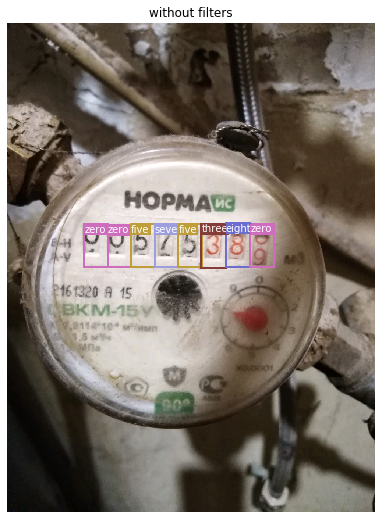

tensor([0., 0., 5., 7., 5., 3., 8., 0.], device='cuda:0')

In [74]:
boxes = pred(rand_image(debug = True))
boxes.shape
boxes[:,6]

Inference Time: 0:00:00.096658


<Figure size 432x288 with 0 Axes>

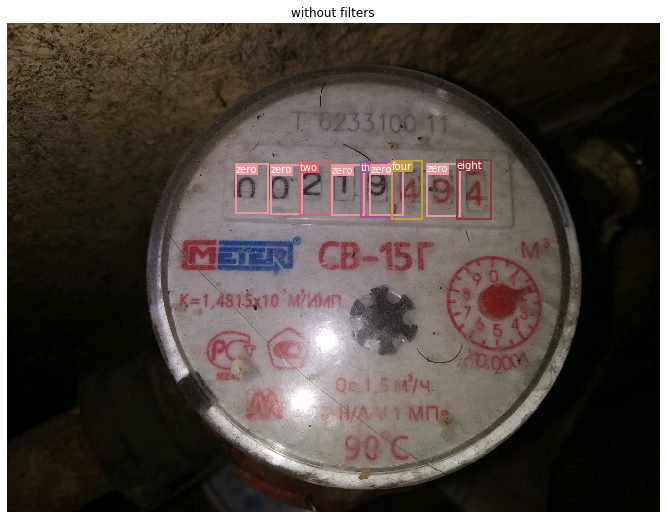

tensor([0., 0., 2., 0., 3., 0., 4., 0., 8.], device='cuda:0')

In [69]:
boxes = pred('data/water_meter/images/id_1062_value_219_494.jpg')
boxes.shape
boxes[:,6]